In [2]:
import requests
import gunicorn
import flask
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

API ini dinominasikan sebagai capstone project yang berguna untuk mengirimkan data kepada user. Proses wrangling dilakukan sesuai endpoint-endpoint dibawah. Base url dari aplikasi ini adalah

Endpoints: 

    1. /bestbook/ methods=['GET']
    Merupakan static endpoint untuk mengembalikan informasi dari books_c.csv dengan rating minimal 4  
    
    2. /rating_book/<value>methods=['GET']
    Merupakan dynamic endpoint untuk mengembalikan informasi dari books_c.csv dengan rating dibawah sesuai dengan keinginan kita dalam bentuk JSON
        
    3. /Genre2012/ methods=['GET']
    Merupakan static endpoint untuk mengembalikan informasi dari chinook.db untuk seluruh invoice dari tahun 2012 untuk genre 'Rock', 'Jazz', 'Metal'

API 1 (Best Book) : Best author(s)?
 - ada 3678 author yang termasuk dlm kategori ini. dicari dengan (unique().size())
 - ada banyak author yang hanya punya 1 buku tapi rating nya 5 karena sedikit 'ratings_count' dan	'text_reviews_count'. Sehingga, kalau diurutkan hanya dari rating, author2 ini lah yang rating nya paling tinggi. Padahal kita sama sekali tidak kenal author-author tsb.
 - lalu, bagaimana cara mencari 10 author terbaik?
 - hypothesis: author terbaik adalah yang rating nya tinggi dan banyak menerbitkan buku
 - buat 'total rating' dan 'mean_rating', lalu tampilkan urutan 'author' 'num_books' dan 'average_rating' berdasarkan 'total_rating'

In [2]:
url1 = 'http://localhost:5000/bestbook'
r = requests.get(url1)
r_bb = pd.DataFrame(r.json())
r_bb.head(15)

ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /bestbook (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001E8007997C0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [ ]:
r_bb.dtypes

In [ ]:
# r_bb['authors'].unique().size
r_bb1=r_bb.reset_index().set_index('authors').groupby(['authors']).sum().sort_values(by='average_rating', ascending=False)
r_bb1['total_rating']=r_bb1['average_rating']
r_bb1['num_books']=r_bb['authors'].value_counts()
r_bb1['mean_rating']=r_bb1['total_rating']/r_bb1['num_books']
r_bb1.head(20)

r_bb1.pivot_table(index='authors', values=['num_books','mean_rating','total_rating']).\
sort_values(by= 'total_rating', ascending=False).iloc[0:10,:]

API 2: Rating Book: Best Indie Book(s)?

- Saya bosan membaca buku-buku dari author terkenal, di waktu-waktu luang saya, saya ingin baca 10-20 buku dari author yang tidak terlalu terkenal tapi ada kemungkinan buku nya menarik!
- Hypothesis: 'average_rating' <= 3.5, 'num_pages' <= 150, 'text_reviews_count' dan 'ratings_count' nya tinggi
- ada 9970 buku dengan 779 author berbeda yang rating nya <=3.5 dicari dengan .unique().size 
- ada 2160 buku dengan 'num_pages' <= 150
- Kita drop column yang kurang perlu, lalu urutkan berdasarkan 'ratings_count', 'text_reviews_count', dan 'average_rating', respectively
- Conclusion: kita bisa lihat buku2 yang lumayan terkenal tapi gak mainstream seperti 'Death of a Salesman', 'Moby Dick',  atau 'Stationary Bike', dan 'Beowulf' utk 20 besar :)

In [ ]:
url2 = 'http://localhost:5000/rating_book/3.5'
r = requests.get(url2)
r_rb = pd.DataFrame(r.json())
r_rb.dtypes
# r_rb.size
# r_rb['authors'].unique().size
# r_rb[r_rb['# num_pages']<= 150].head()

In [ ]:
r_rb1 = r_rb[r_rb['# num_pages']<= 150]
r_rb1.drop(['bookID','isbn','isbn13','language_code'], axis=1, inplace=True)
r_rb1.dtypes

In [ ]:
r_rb1.sort_values(['ratings_count', 'text_reviews_count', 'average_rating'],
                  ascending=[False, False, False]).iloc[0:10,:]

API 3: Genre Invoice

- saya adalah produser musik Rock. saya mau tahu musik rock itu laku di 'BillingCity' dan 'BillingCountry' mana saja selama tengah tahun kedua 2012, ditunjukkan dari berapa total belanja setiap 'CustomerId'
- Dalam data tersebut 'InvoiceDate' diubah menjadi 'datetime64'
- Dalam data tersebut 'BillingCity' dan 'BillingCountry' diubah menjadi 'category'
- Jika ada data 'None' akan diubah menjadi NaN dan di Drop
- Subset dilakukan hanya untuk tahun 2012 saja
- 'CustomerId' 26 dari Fort Worth USA adalah pembeli terbanyak musik Genre Rock
- USA menjadi negara pengkonsumi musik Rock tertinggi, disusul oleh Canada dan Brazil

In [3]:
url3 = 'http://localhost:5000/Genre2012/'
r = requests.get(url3)
r_g2 = pd.DataFrame(r.json())
r_g2['InvoiceDate'] = r_g2['InvoiceDate'].astype('datetime64')
r_g2[['BillingCountry','BillingCity']] = r_g2[['BillingCountry','BillingCity']].astype('category')

r_g20 = r_g2[r_g2['InvoiceDate'] <= '2013-01-01 00:00:00']
r_g20.tail()

,Genre,InvoiceLineId,BillingCity,BillingCountry,CustomerId,InvoiceDate,Total
333324,Rock,1798,Chicago,USA,24,2012-12-30,5.94
333325,Rock,1798,Chicago,USA,24,2012-12-30,5.94
333326,Rock,1798,Chicago,USA,24,2012-12-30,5.94
333327,Rock,1798,Chicago,USA,24,2012-12-30,5.94
333328,Rock,1798,Chicago,USA,24,2012-12-30,5.94


In [4]:
r_g201 = r_g20.loc[:,['BillingCity','BillingCountry']]
r_g2012 =r_g201.melt()
r_g2012
# .reset_index().melt(value_vars=['BillingCity'],id_vars=['BillingCountry'])

,variable,value
0,BillingCity,Copenhagen
1,BillingCity,Copenhagen
2,BillingCity,Copenhagen
3,BillingCity,Copenhagen
4,BillingCity,Copenhagen
...,...,...
666653,BillingCountry,USA
666654,BillingCountry,USA
666655,BillingCountry,USA
666656,BillingCountry,USA


In [5]:
r_g2.groupby(['BillingCountry','BillingCity','CustomerId']).\
sum()['Total'].sort_values(ascending = False).head(10)

BillingCountry  BillingCity          CustomerId
USA             Fort Worth           26            542392.43
Czech Republic  Prague               6             474702.00
France          Dijon                43            415286.43
Czech Republic  Prague               5             415286.43
USA             Orlando              22            366000.43
                New York             18            360812.43
Portugal        Porto                35            360812.43
Brazil          São José dos Campos  1             360812.43
Argentina       Buenos Aires         56            360812.43
France          Paris                39            360812.43
Name: Total, dtype: float64

<AxesSubplot:xlabel='BillingCountry'>

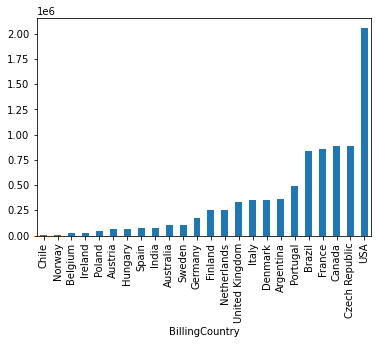

In [6]:
r_g20=r_g2.groupby('BillingCountry').sum()['Total'].sort_values(ascending = True).plot.bar()
r_g20